# Problem Set 5: Credit Card Fraud Detection

**Release Date:** 12 March 2024

**Due Date:** 23:59, 30 March 2024

## Overview

In class, we discussed about logistic regression, and how it can be useful as a classification algorithm. In this problem set, we get some hands-on practice by implementing logistic regression on a Credit Card Fraud Detection dataset. Note that for this problem set, you should only be using the scikit-learn (sklearn) library for the last part (Tasks 5.x) on SVM.

**Required Files**:

* ps5.ipynb
* credit_card.csv
* restaurant_data.csv

**Honour Code**: Note that plagiarism will not be condoned! You may discuss with your classmates and check the internet for references, but you MUST NOT submit code/report that is copied directly from other sources!

## Important

Similar to PS0, your implementation in the following tasks **should NOT involve any iteration, including `map` and `filter`, or recursion**. Instead, you should work with the operations available in NumPy. Solutions that violate this will be penalised.

- You are allowed to use any mathematical functions, but this does not mean that you are allowed to use any NumPy function (there are NumPy functions that aren’t mathematical functions). For example, `np.vectorize` is not allowed since it is iterative. If you are in doubt about which functions are allowed, you should ask in the forum.

There is, however, an exception for **Tasks 3.4 and 3.5**. In the pseudo-code for the algorithm required, there is an explicit for loop. Hence, only for these task you may use **a single for/while loop** to iterate for the number of epochs required.

## Introduction

Fraudulent credit card transaction is a common phenomenon in many parts of the world and can lead to potentially large amounts of losses for both companies and customers. Therefore, we hope to help credit card companies recognize those fraudulent transactions so that customers are not charged for items that they did not purchase.

We are given a dataset that contains transactions made by credit cards holders in `credit_card.csv`. If we think about what type of data might be included in the input variables under the given context, we might realize that those input variables are likely to include word descriptions, such as shop name or locations. In this problem set, we don't need to worry about language processing as the data are pre-processed to contain only numeric values.

## Getting Started

Take a look at the columns in the dataset `credit_card.csv`. We have V1-V20, 'Amount', and 'Time' as input features, and 'Class' as output which takes the value 1 if it's fraud and 0 otherwise. This dataset presents 492 frauds out of 284,807 transactions. That means, there are 284,808 rows (including the header) in the csv file.

We will use this dataset to implement logistic regression using batch and stochastic gradient descent for binary classification.

In [1]:
# Initial imports and setup

import numpy as np
import os
import pandas as pd

from sklearn import svm
from sklearn import model_selection

# Read credit card data into a Pandas dataframe for large tests

dirname = os.getcwd()
credit_card_data_filepath = os.path.join(dirname, 'credit_card.csv')
restaurant_data_filepath = os.path.join(dirname, 'restaurant_data.csv')

credit_df = pd.read_csv(credit_card_data_filepath)
X = credit_df.values[:, :-1]
y = credit_df.values[:, -1:]

## Basics of Pandas

[Pandas](https://pandas.pydata.org/) is an open source data analysis and manipulation tool in Python. In this problem set, we read the CSV into a [Pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to provide some nifty methods that makes it easier for us to handle large amounts of data. You can think of a dataframe as a large table that stores our dataset in a neat and optimized manner, making it fast for retrieval and manipulation and data. Using Pandas, we can quickly gain an overview of the type and values of the data stored, distributions of values within the dataset, and even ways to perform sampling.

In the new few sections, we will explore some basic functions of Pandas to help us get started. You do not need to submit any codes for this section, and can simply run the cells to follow along.

### Exploring the dataset

Using the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) method on the dataframe, we can get an overview of the data. By default, the method returns the first 5 entries in the dataframe.

In [2]:
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,69.99,0


Next, we can inspect the [value counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) of the 'Class' property in the dataframe to know the number of fraudulent and non-fraudulent transactions.

In [3]:
# Inspect the number of fraudulent and non-fraudulent transactions.
credit_df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Indexing and selecting data

Similar to NumPy, we can also index and select data on Pandas dataframes.

For example, we can [select columns in the dataframe by their labels](https://pandas.pydata.org/docs/user_guide/indexing.html#basics). In the following example, we use `'Class'` to index the 'Class' column in the credit dataframe.

In [4]:
# Select the 'Class' column in the credit dataframe
credit_df['Class']

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

Or, we can use integer indexing.

In [5]:
# Obtain the first 2 rows
credit_df[0:2]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,2.69,0


We can also [select columns in the dataframe that fulfils some condition](https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing). In the example below, `credit_df['Class'] == 0` returns a [Pandas Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) of length 284807, which is the size of our dataset. It contains the value `True` if and only if the `Class` value for the particular entry is of value 0, and `False` otherwise. We can use this Boolean series to index the credit dataframe to return the rows where the `Class` field is 0. Does this remind you of how NumPy arrays operate?

In [6]:
credit_df['Class'] == 0

0         True
1         True
2         True
3         True
4         True
          ... 
284802    True
284803    True
284804    True
284805    True
284806    True
Name: Class, Length: 284807, dtype: bool

In [7]:
# Obtain the credit dataframe where the 'Class' field is 0
credit_df[credit_df['Class'] == 0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,10.00,0


You can also [concatenate](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) Pandas series or dataframes together! In this example, we explored how we can concat the first 2 rows and last 2 rows of the dataframe. Similar to NumPy, you would also need to specify the axis for concatenation.

In [8]:
pd.concat([credit_df[:2], credit_df[-2:]], axis=0)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,2.69,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,217.00,0


## Data Processing

As you might have realised, managing Pandas is not so much different from how you would operate on NumPy or basic Python structures! We have provided some teaser on basic Pandas. Now, we will see how we can use Pandas to help us in resampling.

In particular, you might find the [`sample` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) helpful in this section.

### Task 1.1: Problem with imbalanced data

Our first task is to describe in one or two sentences what problem we might encounter if we directly use the given dataset without processing it.

Hint: consider the 'Class' column, and think about how a high accuracy prediction can be achieved in a wrong way

### Task 1.2: Resampling methods

When we are faced with the issue of imbalanced data, there are several ways to deal with it. A more direct way might be just to collect more data instances. We realized that in our case this doesn't work well because the events unevenly occur. We then look at how to resample the existing instances.

In this problem set, you are introduced with three resampling methods: undersampling, oversampling, and SMOTE.

#### Concept 1.2.1: Undersampling

<figure align="center">
<img src="imgs/undersampling.png" alt="visualisation of undersampling" width="50%">
<figcaption style="text-align:center">Figure 1: Visualisation of undersampling.</figcaption>
</figure>

The figure above illustrates undersampling. In undersampling, we remove samples from the majority class. More specifically, we randomly take subsamples of the majority class such that the size of two classes is the same.

#### Task 1.2.1: Random undersampling in practice

Your task is to observe the data in `credit_card.csv` and randomly remove some observations of the majority class until the two classes balance out.

In [9]:
def random_undersampling(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Given credit card dataset with 0 as the majority for 'Class' column. Returns credit card data with two classes
    having the same shape, given raw data read from csv.

    Parameters
    ----------
    df: pd.DataFrame
        The potentially imbalanced dataset.

    Returns
    -------
    Undersampled dataset with equal number of fraudulent and legitimate data.
    '''
    fraud_df = df[df['Class'] == 1]
    non_fraud_df = df[df['Class'] == 0]
    
    non_fraud_subsample = non_fraud_df.sample(n = len(fraud_df), random_state = 10)
    
    return pd.concat([fraud_df, non_fraud_subsample])
    

In [10]:
# small data
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1], [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
# checks that the randomly undersampled dataset has 3 fraudulent and 3 legitimate data points
assert np.all(np.equal(random_undersampling(df1)['Class'].value_counts(), (3, 3)))

# credit card data
assert np.all(np.equal(random_undersampling(credit_df)['Class'].value_counts(), (492, 492)))

Now you might realize the drawback of undersampling - by removing data randomly, you might have removed some valuable information from the dataset. Is there any way to do better without losing the valuable information?

#### Concept 1.2.2: Oversampling

<figure align="center">
<img src="imgs/oversampling.png" alt="visualisation of oversampling" width="50%">
<figcaption style="text-align:center">Figure 2: Visualisation of oversampling.</figcaption>
</figure>

The figure above illustrates oversampling. In oversampling, we duplicate records of the minority class such that the size of two classes balance out.

#### Task 1.2.2: Oversampling in practice

Your task is to observe the data in `credit_card.csv` and apply the oversampling technique to the dataset.

In [11]:
def random_oversampling(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Given credit card dataset with 0 as the majority for 'Class' column. Returns credit card data with two classes
    having the same shape, given raw data read from csv.

    Parameters
    ----------
    df: pd.DataFrame
        The potentially imbalanced dataset.

    Returns
    -------
    Oversampled dataset with equal number of fraudulent and legitimate data.
    '''

    fraud_df = df[df['Class'] == 1]
    non_fraud_df = df[df['Class'] == 0]
    
    new_fraud_sample = fraud_df.sample(n = len(non_fraud_df), random_state = 10, replace = True, axis = 0)
    
    return pd.concat([non_fraud_df, new_fraud_sample])

In [12]:
# small data
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],
        [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
assert np.all(np.equal(random_oversampling(df1)['Class'].value_counts(), (6, 6)))

# credit card data
assert np.all(np.equal(random_oversampling(credit_df)['Class'].value_counts(), (284315, 284315)))

You might realize the bright side of oversampling - you don't lose certain valuable information. At the same time, you also realize the drawback of oversampling - it can cause overfitting and a poor generalization of the test set. Now the question is, instead of simply duplicating records, is there any other way to increase the number of records in the minority set?

#### Concept 1.2.3: SMOTE (for further reading only)

<figure align="center">
<img src="imgs/smote.png" alt="visualisation of SMOTE" width="50%">
<figcaption style="text-align:center">Figure 3: Visualisation of SMOTE.</figcaption>
</figure>

The figure above illustrates Synthetic Minority Oversampling Technique (SMOTE).

The SMOTE algorithm works in these four steps:

1. Consider minority and majority instances in vector space.
1. For each minority-class instance pair, interpolate their feature values.
1. Randomly synthesize instances and label with minority class
1. More instances added to minority class

In this case, you increase the number of minority instances without simply duplicating the values. Now your newly inserted minority record is not an exact copy of an existing data point, but it is also not too different from the known observations in your minority class. Outside this problem set, when we want to do data resampling, we can use the [Python imbalanced-learn library](https://pypi.org/project/imbalanced-learn/). We will not be implementing SMOTE algorithm for this problem set.

#### Word of caution when resampling

In the section above, we introduced three resampling techniques. One very important thing to note is, in practice you should first split dataset to train–test sets, then resample the train dataset before training the model. This is done to avoid data leakage (snooping).

Data leakage can cause you to create overly optimistic if not completely invalid predictive models. It is when information from outside the training dataset is used to train the model. The additional information might allow the model to learn something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

## Splitting data

Before we can start training our models, we need to **randomly** partition our dataset into training data and testing data. Remember that we are trying to make a model that can predict fraudulence of data points that the model has never seen. It would be unwise to measure the accuracy of the model using the same data it trained on.

### Task 2.1: Splitting data

In this task, you need to implement `train_test_split`. This function takes `X`, `y`, and `test_size` as arguments, and output `X_train`, `X_test`, `y_train`, and `y_test` you obtained.

In [13]:
def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float=0.25):
    '''
    Randomly split the data into two sets.

    Parameters
    ----------
    X: np.ndarray
        (m, n) dataset (features).
    y: np.ndarray
        (m,) dataset (corresponding targets).
    test_size: np.float64
        fraction of the dataset to be put in the test dataset.

    Returns
    -------
    A tuple of four elements (X_train, X_test, y_train, y_test):
    X_train: np.ndarray
        (m - k, n) training dataset (features).
    X_test: np.ndarray
        (k, n) testing dataset (features).
    y_train: np.ndarray
        (m - k,) training dataset (corresponding targets).
    y_test: np.ndarray
        (k,) testing dataset (corresponding targets).
    '''

    m = X.shape[0]
    
    #obtain actual number of samples for testing
    k = int(m * test_size)
    
    indices = np.arange(m)
    np.random.shuffle(indices)
    
    #k for training, rest for test, ensures non overlapping & distinct
    train_indices, test_indices = indices[k:], indices[:k]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test
    

In [14]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 30, 0], [111.4, 40, 0], [111.5, 50, 0], [111.6, 60, 1],
        [111.7, 70, 0], [111.8, 80, 1], [111.9, 90, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1 = [7, 2, 7, 2]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25)

assert len(X1_train) == expected1[0] and\
    len(X1_test) == expected1[1] and\
    len(y1_train) == expected1[2] and\
    len(y1_test) == expected1[3]

## Logistic regression

### Gradient descent

Recall the gradient descent method you learned and applied in the previous problem set. Gradient descent is an iterative optimization method which finds the minimum of a differentiable function. It's often used to find the coefficients that minimize the cost function. Here is a brief recap of how that's done:

<figure align="center">
<img src="imgs/gradient_descent.png" alt="visualisation of gradient descent" width="50%">
    <figcaption style="text-align:center"><a href="https://medium.com/@divakar_239/stochastic-vs-batch-gradient-descent-8820568eada1">Figure 4: Visualisation of gradient descent.</a></figcaption>
</figure>

We start at an initial weight vector $\mathbf{w} = (w_0, w_1, ..., w_n)$. Then we take incremental steps along the steepest slope to get to the bottom where the minimum cost lies. Along the way, we keep updating the weight coefficients by computing the gradients using the training samples from the training dataset.

### Concept: Batch gradient descent

In batch gradient descent, **all** the training data (entire batch) is taken into consideration in a single step. For one step of gradient descent, we calculate $w_j \leftarrow w_j - \alpha \frac{\partial J(\mathbf{w})}{\partial w_j}$ (where $\alpha$ is the learning rate) simultaneously for all $j$ based on all the training examples and then use that mean gradient to update our parameters.

By continuing this for iterations until convergence, or until it's time to stop, we reach the optimal or near optimal parameters $\mathbf{w}$ leading to minimum cost.

### Concept: Stochastic gradient descent

Think about what's a limitation of the (entire) batch gradient descent introduced earlier. What if the dataset is very large? In Stochastic Gradient Descent (SGD), we consider only the error on a single record $(x^{(*)}, y^{(*)})$ at a time. How does this work?

During the training loop, we will randomly sample an instance in the dataset. This instance will be used to update the weights of the model $w_j \leftarrow w_j - \alpha \frac{\partial J(\mathbf{w})}{\partial w_j}$ (where $\alpha$ is the learning rate) simultaneously for all $j$.

Note that SGD does not necessarily decrease the batch loss in each iteration! However, on average, the loss will still decrease. Since we work on only a single record at any time, SGD provides the advantage of a much smaller memory requirement, and faster computation time. SGD also comes with its own set of disadvantages, for example, we lose benefits of any vectorization.

### Concept: Gradient descent termination condition

The next question is when to stop? The ideal case is to run until convergence, but convergence might be hard to obtain. Here are some criterias you can use:

* Stop when error change is small and/or
* Stop when error is small
* Stop when maximum number of iterations is reached

Now let's try to apply the batch gradient descent and stochastic gradient descent.
Task 3.1 to 3.4 will gradually guide you to complete the logistic regression using batch gradient descent, while task 3.5 expects you to implement the stochastic one. For the task in this problem set, you can assume that the bias column has been added for all input `X`. That means given `X` as an argument, you don't need to manually add the bias column again in your code.

### Task 3.1: Cost function

Recall that for logistic regression, we want an error function for an individual value to be:

<figure align="center">
<img src="imgs/piecewise_error.png" alt="error function" width="50%">
<figcaption style="text-align:center">Figure 5: Cost function.</figcaption>
</figure>

We can simplify the condition and transform it into the equivalent cost function:

<figure align="center">
<img src="imgs/error.png" alt="error function as a line" width="50%">
<figcaption style="text-align:center">Figure 6: Cost without conditions.</figcaption>
</figure>

In this task, you need to implement `cost_function` $E$ as mentioned above. This function takes `X`, `y`, and `weight_vector` $\mathbf{w}$ as arguments, and returns the error $E$. Note that for this task, the $E$ should account for **all** the training data.

Here, we are using the $\log$ function and we need to handle the case of computing $\log(0)$. There are many ways to handle this. In this task, we will handle $\log(0)$ by using the machine epsilon for numpy `float64` type, and use the trick $\log(x + eps)$ which allows $x$ to be $0$. If $x$ was any other value, $\log(x + eps)$ would be very close to $\log(x)$. This helps to improve numerical stability in computation.

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost_function(X: np.ndarray, y: np.ndarray, weight_vector: np.ndarray):
    '''
    Cross entropy error for logistic regression

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features).
    y: np.ndarray
        (m,) training dataset (corresponding targets).
    weight_vector: np.ndarray
        (n,) weight parameters.

    Returns
    -------
    Cost
    '''
    
    # Machine epsilon for numpy `float64` type
    eps = np.finfo(np.float64).eps

    y_pred = sigmoid(X @ weight_vector)
    
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    error = -y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)
    
    cost = np.sum(error) / len(y)
    
    return cost

In [16]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1], [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([0.002, 0.1220])

assert np.round(cost_function(X1, y1, w1), 5) == np.round(1.29333, 5)

### Task 3.2: Weight update

In this task, you need to implement `weight_update`. This function takes `X`, `y`, `alpha`, and a `weight_vector` as arguments, and output the new weight vector. Each call to the function should make one update on the weight vector.

In [17]:
def weight_update(X: np.ndarray, y: np.ndarray, alpha: np.float64, weight_vector: np.ndarray) -> np.ndarray:
    '''
    Do the weight update for one step in gradient descent

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features).
    y: np.ndarray
        (m,) training dataset (corresponding targets).
    alpha: np.float64
        logistic regression learning rate.1
    weight_vector: np.ndarray
        (n,) weight parameters.

    Returns
    -------
    New weight vector after one round of update.
    '''
    
    y_pred = sigmoid(X @ weight_vector)

    gradient = X.T @ (y_pred - y) / len(y)
    
    return weight_vector - alpha * gradient
    

In [18]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],[111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([2.2000, 12.20000])
a1 = 1e-5
nw1 = np.array([2.199,12.2])

assert np.array_equal(np.round(weight_update(X1, y1, a1, w1), 3), nw1)

### Task 3.3: Logistic regression classification

Remember that logistic regression is used for classification even though the function gives a probability output. In this task, you classify each element in `X`, given `weight_vector` using `prob_threshold` as the threshold, and output the classification result as an `np.ndarray`.

If the probability predicted by the `weight_vector` exceeds the `prob_threshold`, we should classify it as fraud (`y = 1`). Otherwise, we should classify it as legitimate (`y = 0`).

In [19]:
def logistic_regression_classification(X: np.ndarray, weight_vector: np.ndarray, prob_threshold: np.float64=0.5):
    '''
    Do classification task using logistic regression.

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features).
    weight_vector: np.ndarray
        (n,) weight parameters.
    prob_threshold: np.float64
        the threshold for a prediction to be considered fraudulent.

    Returns
    -------
    Classification result as an (m,) np.ndarray
    '''

    y_pred = sigmoid(X @ weight_vector)
    
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred

In [20]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],[111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([-0.000002, 0.000003])
expected1 = np.transpose([0, 0, 0, 0, 0, 0, 0, 1, 0])
result1 = logistic_regression_classification(X1, w1)

assert result1.shape == expected1.shape and (result1 == expected1).all()

### Task 3.4: Logistic regression using batch gradient descent

In this task, you need to implement a fixed learning rate algorithm for logistic regression. This function takes `X_train`, `y_train`, `max_num_epochs`, `threshold`, and `alpha` as arguments, and output the final `weight_vector` you obtained. You can make use of the previous functions you have implemented earlier.

Specifically, an epoch refers to one complete pass through the dataset. Hence, one iteration of gradient descent, which simultaneously updates the weight vector based on the cost function computed on the entire dataset, corresponds to one epoch. Batch gradient descent is terminated when the number of update rounds exceeds the maximum number of epochs (`max_num_epochs`) given, or when the computed error falls below the threshold value (`threshold`).

In [21]:
def logistic_regression_batch_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int = 250, threshold: np.float64 = 0.05, alpha: np.float64 = 1e-5):
    '''
    Initialize your weight to zeros. Write your terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector. Use that to do predictions, and output the final weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (m, n) training dataset (features).
    y_train: np.ndarray
        (m,) training dataset (corresponding targets).
    max_num_epochs: int
        this should be one of the terminating conditions. 
        That means if you initialize num_update_rounds to 0, 
        then you should stop updating the weights when num_update_rounds >= max_num_epochs.
    threshold: np.float64
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    alpha: np.float64
        logistic regression learning rate.

    Returns
    -------
    The final (n,) weight parameters
    '''
    iterations = int(0)
    m,n = X_train.shape
    weight_vector = np.zeros(n)
    
    while iterations < max_num_epochs:
        
        weight_vector = weight_update(X_train, y_train, alpha, weight_vector)
        
        cost = cost_function(X_train, y_train, weight_vector)
        
        if (cost <= threshold):
            break
        
        iterations += 1
    
    return weight_vector

In [22]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],[111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
max_num_epochs1 = 20
expected1 = np.transpose([-0.0011538251272737235, 0.0019538526326272542])

assert np.array_equal(np.round(logistic_regression_batch_gradient_descent(X1, y1, max_num_epochs1), 5), np.round(expected1, 5))

### Task 3.5: Logistic regression using stochastic gradient descent

In this task, you need to implement logistic regression using stochastic gradient descent. This function takes `X_train`, `y_train`, `max_num_iterations`, `threshold`, and `alpha` as arguments, and output the final `weight_vector` you obtained. You can make use of the previous functions you have implemented earlier.

For this task, you should use `np.random.choice` to randomly choose the training data for each iteration. You should also use the `seed` argument to set the random seed for reproducibility.

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def weight_update_stochastic(X: np.ndarray, y: np.ndarray, alpha: np.float64, weight_vector: np.ndarray) -> np.ndarray:
    '''
    Do the weight update for one step in gradient descent.

    Parameters
    ----------
    X: np.ndarray
        (1, n) training dataset (features).
    y: np.ndarray
        one y in training dataset (corresponding targets).
    alpha: np.float64
        logistic regression learning rate.
    weight_vector: np.ndarray
        (n, 1) vector of weight parameters.

    Returns
    -------
    New (n,) weight parameters after one round of update.
    '''    
    
    random_index = np.random.choice(X.shape[0])
    
    x_sample = X[random_index]
    
    y_pred = sigmoid(x_sample @ weight_vector)
    
    return weight_vector - alpha * ((y_pred - y) * x_sample)
    

In [24]:
def logistic_regression_stochastic_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_iterations: int=250, threshold: np.float64=0.05, alpha: np.float64=1e-5, seed :int=43) -> np.ndarray:
    '''
    Initialize your weight to zeros. Write a terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (m, n) training dataset (features).
    y_train: np.ndarray
        (m,) training dataset (corresponding targets).
    max_num_iterations: int
        this should be one of the terminating conditions. 
        The gradient descent step should happen at most max_num_iterations times.
    threshold: np.float64
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    alpha: np.float64
        logistic regression learning rate.
    seed: int
        seed for random number generation.

    Returns
    -------
    The final (n,) weight parameters
    '''
    np.random.seed(seed)
    
    m,n = X_train.shape
    weight_vector = np.zeros(n)
    
    for i in range(max_num_iterations):
        cost = cost_function(X_train, y_train, weight_vector)
        if (cost <= threshold):
            break
        random_index = np.random.randint(m)
        
        x_sample = X_train[random_index]
        y_sample = y_train[random_index]
        
        y_pred = sigmoid(x_sample @ weight_vector)
        
        gradient = x_sample * (y_pred - y_sample)
            
        weight_vector -= alpha * gradient
        
    return weight_vector

In [25]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],[111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1 = cost_function(X1, y1, np.transpose(np.zeros(X1.shape[1])))

assert cost_function(X1, y1, logistic_regression_stochastic_gradient_descent(X1, y1)) < expected1

### Task 3.6.1: Stochastic gradient descent vs batch gradient descent

Recall that it is ideal for gradient descent to run until convergence, but convergence might be hard to obtain.

In this task, we will explore the relationship between the cross entropy loss vs the number of update rounds and/or the runtime it takes to run the update for both batch gradient descent (task 3.4) and stochastic gradient descent (task 3.5) using sample of `credit_card` dataset.

To guide us in our explorations, let's start by collecting empirical results from running stochastic gradient descent and batch gradient descent. You will need to make the following 2 plots with the stated specifications:

1. Plot of cross entropy loss against number of update rounds
    - $x$-axis label: "Number of Update Rounds"
    - $y$-axis label: "Cross Entropy Loss"
    - Title: "Plot of cross entropy loss against number of update rounds"
    - Legend to specify the data points corresponding to "Batch Gradient Descent" and "Stochastic Gradient Descent" respectively
2. Plot of cross entropy loss against runtime (sec)
    - $x$-axis label: "Runtime (sec)"
    - $y$-axis label: "Cross Entropy Loss"
    - Title: "Plot of cross entropy loss against runtime (sec)"
    - Legend to specify the data points corresponding to "Batch Gradient Descent" and "Stochastic Gradient Descent" respectively

For both plots, put both methods (batch gradient descent and stochastic gradient descent) in one diagram. Also ensure that the runtime is the cumulative runtime not the runtime per individual update round. 

You can refer to following script for creating these plots. Feel free to modify it if necessary.

Once you are done, paste your plots in the corresponding answer box in Coursemology.

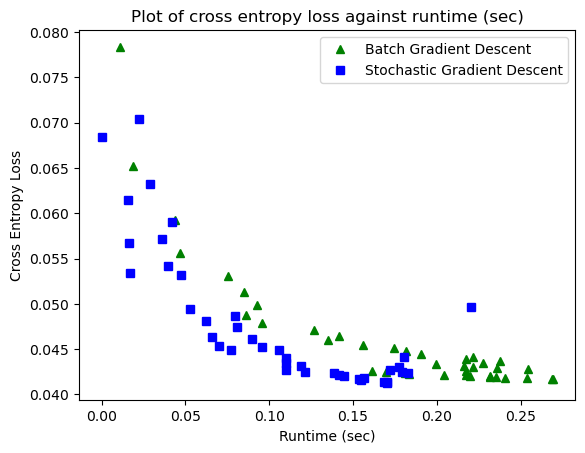

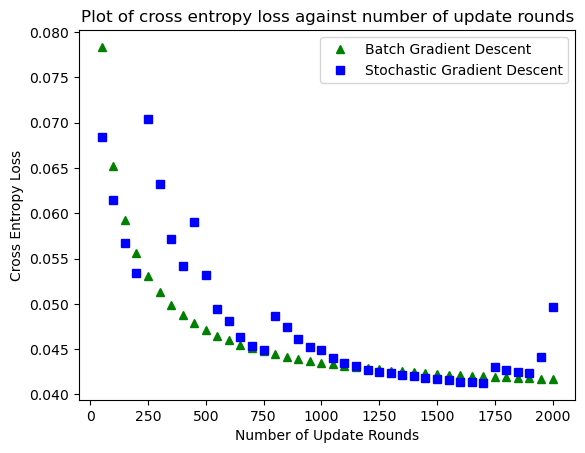

In [26]:
import matplotlib.pyplot as plt
from time import time

X_sample, y_sample = X[:1500], y[:1500].reshape(-1)
num_interations = 2000
batch_times = []
batch_costs = []
batch_rounds = []

for i in range(50, num_interations + 1, 50):
    start = time()
    weight_vector = logistic_regression_batch_gradient_descent(X_sample, y_sample, i, 0, 1e-5)
    stop = time()
    batch_times.append(stop - start)
    batch_costs.append(cost_function(X_sample, y_sample, weight_vector))
    batch_rounds.append(i)
plt.plot(batch_times, batch_costs, 'g^', label="Batch Gradient Descent")

stochastic_times = []
stochastic_costs = []
stochastic_rounds = []
for i in range(50, num_interations + 1, 50):
    start = time()
    weight_vector = logistic_regression_stochastic_gradient_descent(X_sample, y_sample, i, 0, 1e-5)
    stop = time()
    stochastic_times.append(stop - start)
    stochastic_costs.append(cost_function(X_sample, y_sample, weight_vector))
    stochastic_rounds.append(i)
plt.plot(stochastic_times, stochastic_costs, 'bs', label="Stochastic Gradient Descent")

plt.xlabel('Runtime (sec)')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Plot of cross entropy loss against runtime (sec)')

plt.show()


plt.plot(batch_rounds, batch_costs, 'g^', label="Batch Gradient Descent")
plt.plot(stochastic_rounds, stochastic_costs, 'bs', label="Stochastic Gradient Descent")

plt.xlabel('Number of Update Rounds')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Plot of cross entropy loss against number of update rounds')

plt.show()


### Task 3.6.2: Stochastic gradient descent vs batch gradient descent

With reference to the 2 plots that you have made in task 3.6.1, what do you observe about the relationship between the cross entropy loss vs the number of update rounds and/or the runtime it takes to run the update for both batch gradient descent (task 3.4) and stochastic gradient descent (task 3.5)? Explain your observations in terms of the effect of size of data, number of update rounds, runtime and whether the algorithm will be stuck in a local minima and so on.

## Multi-class logistic regression

Now that you have helped the credit card companies recognize fraudulent transactions, customers are less likely to be charged for items that they did not purchase. They are very satisfied with how well your model performed. They want to offer you a meal, at a restaurant of your choice. You decide to make your choice based on the occupancy of the restaurant. Luckily for you, you have some starting data `restaurant_data.csv` to work with. The dataset provides three input features "max_capacity", "feedback_score", and "average_expense", and an output feature "occupancy" that takes the value of "none", "some", or "full".

### Task 4.1: Multi-class logistic regression using batch gradient descent

In this task, you need to implement a fixed learning rate algorithm for multi-class logistic regression. This function takes `X_train`, `y_train`, `max_num_epochs`, `threshold`, `alpha`, and `class_i` as arguments, and output the final `weight_vector` you obtained. Here, argument `class_i` is the class that you want to train in this round. You can make use of the previous functions you have implemented earlier.

In [27]:
def multi_class_logistic_regression_batch_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int, threshold: np.float64, alpha: np.float64, class_i: str) -> np.ndarray:
    '''
    Initialize your weight to zeros. Write your terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector. Output the resulting weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (m, n) training dataset (features).
    y_train: np.ndarray
        (m,) training dataset (corresponding targets).
    alpha: np.float64
        logistic regression learning rate.
    max_num_epochs: int
        this should be one of the terminating conditions. 
        That means if you initialize num_update_rounds to 0, 
        then you should stop updating the weights when num_update_rounds >= max_num_epochs.
    threshold: float
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    class_i: string
        one of 'none', 'full', 'some'.

    Returns
    -------
    The final (n,) weight parameters
    '''
    y_binary = (y_train == class_i).astype(np.float64)
    
    m, n = X_train.shape
    weight_vector = np.zeros(n)
    
    for _ in range(max_num_epochs):
        weight_vector = weight_update(X_train, y_binary, alpha, weight_vector)
        
        cost = cost_function(X_train, y_binary, weight_vector)
        
        if (cost <= threshold):
            break
    
    return weight_vector

In [28]:
data1 = [[26, 9, 69, 'full'],
        [54, 3, 16, 'some'],
        [59, 7, 50, 'some' ],
        [33, 0, 45, 'full']]
df1 = pd.DataFrame(data1, columns = ['max_capcity', 'feedback_score', 'average_expense', 'occupancy'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
max_num_epochs1 = 20
expected1 = np.transpose([6.75, 0.125, -6.0])
assert np.array_equal(multi_class_logistic_regression_batch_gradient_descent(X1, y1, max_num_epochs1, 0.05, 1, 'some'), expected1)

### Task 4.2: Do classification on multi-class problem

Finally, you classify each element in `X`, given three weight vectors `weight_vector_none`, `weight_vector_some`, and `weight_vector_full`, and output a list of classification results in the form of an array (`['some', 'none', 'full', 'none', ...]`). Note that in the case of a tie, you can choose the class in the order of priority: `'none'`, `'some'`, `'full'`. You can make use of the previous functions you have implemented earlier.

In [29]:
def classification(x, weight_vector_none, weight_vector_some, weight_vector_full):
    prob_none = sigmoid(x @ weight_vector_none)
    prob_some = sigmoid(x @ weight_vector_some)
    prob_full = sigmoid(x @ weight_vector_full)
    
    if prob_none >= prob_some and prob_none >= prob_full:
        return 'none'
    elif prob_some >= prob_full:
        return 'some'
    else:
        return 'full'
    

def multi_class_logistic_regression_classification(X: np.ndarray, weight_vector_none: np.ndarray, weight_vector_some: np.ndarray, weight_vector_full: np.ndarray):
    '''
    Do classification task using logistic regression.
    In the case of a tie, break the tie in the priority 'none' > 'some' > 'full'.

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features)
    weight_vector_none: np.ndarray
        (n,) weight parameters for the 'none' class.
    weight_vector_some: np.ndarray
        (n,) weight parameters for the 'some' class.
    weight_vector_full: np.ndarray
        (n,) weight parameters for the 'full' class.

    Returns
    -------
    Classification result as an (m,) np.ndarray. Eg ['some', 'none', 'full', ... ,'none'].
    '''
    m, n = X.shape
    class_labels = []
    
    for i in range(m):
        instance = X[i]
        class_label = classification(instance, weight_vector_none, weight_vector_some, weight_vector_full)
        class_labels.append(class_label)
    
    return np.array(class_labels)

In [30]:
data1 = [[26, 9, 69, 'full'],
        [54, 3, 16, 'some'],
        [59, 7, 50, 'some' ],
        [33, 0, 45, 'full']]
df1 = pd.DataFrame(data1, columns = ['max_capcity', 'feedback_score', 'average_expense', 'occupancy'])
X1 = df1.iloc[:, :-1].to_numpy()

w11 = np.transpose([0.0013351567670329624, 2.5757816929896605e-05, -0.001189020140476165])
w12 = np.transpose([2.5757816929896605e-05, -0.001189020140476165, 0.0013351567670329624])
w13 = np.transpose([2.5757816929896605e-05, 0.0013351567670329624, -0.001189020140476165])
expected1 = np.transpose(['some', 'none', 'some', 'some'])

result1 = multi_class_logistic_regression_classification(X1, w11, w12, w13)

assert result1.shape == expected1.shape and (result1 == expected1).all()

## Support Vector Machine

Now let's apply the support vector machine we learnt in lecture to the credit card dataset. Here is a quick recap of what SVM is about: We are given a training dataset of $n$ points of the form $(x^{(i)}, y^{(i)})$, where the $y^{(i)}$ are either 1 or 0, each indicating the class to which the point $x^{(i)}$ belongs.

Each $x^{(i)}$ $n$-dimensional real vector. We want to find the "maximum-margin hyperplane" that divides the group of points $x^{(i)}$ for which $y_{i}=1$ from the group of points for which $y_{i}=0$, which is defined so that the distance between the hyperplane and the nearest point $x^{(i)}$ from either group is maximized.

<figure align="center">
<img src="imgs/svm.png" alt="visualisation of support vector machine" width="50%">
<figcaption style="text-align:center">Figure 7: Visualisation of support vector machine.</figcaption>
</figure>

How can we do construct such a "maximum-margin hyperplane"? Recall that in the lecture, we formulated SVMs as the following minimization problem:

$$
\min_{w} C \left[\sum_{i = 1}^{m} y^{(i)}\ Cost_1(\mathbf{w}^{T} \mathbf{x}^{(i)}) + (1 - y^{(i)})\ Cost_0(\mathbf{w}^{T} \mathbf{x}^{(i)})\right] + \frac{1}{2} \sum_{i = 1}^{n} \mathbf{w}_i^2 $$

where $Cost_1(\mathbf{w}^T \mathbf{x}^{(i)}) = \max(0, 1 - \mathbf{w}^T \mathbf{x}^{(i)})$ and $Cost_0(\mathbf{w}^T \mathbf{x}^{(i)}) = \max(0, 1 + \mathbf{w}^T \mathbf{x}^{(i)})$, with the hypothesis function $h_\mathbf{w}(\mathbf{w}) = 1$ if $\mathbf{w}^T \mathbf{x} \geq 0$, and 0 otherwise.

In particular, the summand term is known as the *hinge loss*. Thus, when $y^{(i)} = 0$, the more negative $\mathbf{w}^T \mathbf{x}$ is, the more $Cost_1$ penalises the model. Similarly, $Cost_0$ penalises the model the further $\mathbf{w}^T \mathbf{x}$ strays from the negative region. Notice how the cost function aligns with the goal of the hypothesis function?

Furthermore, we also add a regularization parameter $C$ to the cost function to balance the trade-off between margin maximization and loss.

Thus, solving this minimization problem allows us to find the weight vector $\mathbf{w}$ that provides the maximum-margin hyperplane while balancing the trade-off of overfitting.

With this set up in mind, how can we implement this in code? Thankfully, with modern machine learning libraries, much of the tedious work of solving this minimization problem has been done. As machine learning practitioners, one popular library that we commonly use (aside from [NumPy](https://numpy.org/doc/stable/index.html)) is [scikit-learn](https://scikit-learn.org/), which is built on top of NumPy and provides simple and efficient tools to implement common machine learning algorithms.

In particular, we will look at how we can use the [scikit-learn](https://scikit-learn.org/) library to implement SVM.

### Task 5.1: Linear SVM

Take a look at the Python library [scikit-learn](https://scikit-learn.org/stable/modules/svm.html). It has been imported for your use. In this task, the function takes `X`, `y`. Note that here `X` and `y` are not training set but the entire dataset, so you are asked to do a train test data split with `test_size` of 0.3, and `random_state` of 42, **using what's provided in the library** (not what you implemented in task 2.1). Then, create an instance of a Linear SVM classifier using the default parameters, train the Linear SVM classifier, and output the predictions as well as the accuracy score. Note that the default kernel in sklearn is RBF, so you need to specify the kernel type you want to use.

**For this task, you should make full use of the library functions, instead of doing computations on your own.**

In particular, you can look into the scikit-learn methods to perform a [train-test data split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and employ the [SVC model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def linear_svm(X: np.ndarray, y: np.ndarray):
    '''
    Do classification using linear svm. Given X and y, note that here X and y are not training sets, but rather the
    entire dataset. Do a train test data split with test_size=0.3, and random_state=42.

    Parameters
    ----------
    X: np.ndarray
        (m, n) whole dataset (features)
    y: np.ndarray
        (m,) whole dataset (corresponding targets)

    Returns
    -------
    pred: np.ndarray
        The predictions.
    acc: np.float64
        The accuracy on a scale up to 100.
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    #create an instance of a Linear SVM classifier using the default parameters, train the Linear SVM classifier, and output the predictions as well as the accuracy score
    svm_classifier = SVC(kernel = 'linear')
    
    svm_classifier.fit(X_train, y_train)
    
    y_pred = svm_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    
    print(accuracy)
    print(y_pred)
    
    return y_pred, accuracy
    

In [57]:
# small data
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1_y = np.transpose([0, 0, 1])
expected1_accuracy = 66.66666666666666
result1 = linear_svm(X1, y1)
assert (result1[0] == expected1_y).all() and (result1[0]).shape == expected1_y.shape and round(result1[1], 5) == round(expected1_accuracy, 5)

# subset of credit card data
class_0 = credit_df[credit_df['Class'] == 0]
class_1 = credit_df[credit_df['Class'] == 1]

data_0 = class_0.sample(n=15, random_state=42)
data_1 = class_1.sample(n=50, random_state=42)
data_100 = pd.concat([data_1, data_0], axis=0)
X = data_100.iloc[:, :-1].to_numpy()
y = data_100.iloc[:, -1].to_numpy()

expected_pred = np.transpose([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
expected_accuracy = 80.0
result = linear_svm(X, y.ravel())
assert (result[0] == expected_pred).all() and (result[0]).shape == expected_pred.shape and round(result[1], 5) == round(expected_accuracy, 5)

66.66666666666666
[0 0 1]
80.0
[1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Task 5.2: Gaussian Kernel SVM

Similarly, you will use scikit-learn to implement a Gaussian Kernel SVM. In this task, the function takes `X`, `y`. Note that here `X` and `y` are not training set but the entire dataset, so you are asked to do a train test data split with `test_size` of 0.3, and `random_state` of 42, using what's provided in the library. Then, create an instance of a Gaussian Kernel SVM classifier using the default parameters, train the Gaussian Kernel SVM classifier, and output the predictions as well as the accuracy score.

**For this task, you should make full use of the library functions, instead of doing computations on your own.**

As before, you can look into the scikit-learn methods to perform a [train-test data split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and employ the [SVC model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [58]:
def gaussian_kernel_svm(X: np.ndarray, y: np.ndarray):
    '''
    Do classification using Gaussian Kernel svm. Given X and y, note that here X and y are not training sets, but
    rather the entire dataset. Do a train test data split with test_size=0.3, and random_state=42.

    Parameters
    ----------
    X: np.ndarray
        (m, n) whole dataset (features)
    y: np.ndarray
        (m,) whole dataset (corresponding targets)

    Returns
    -------
    pred: np.ndarray
        The predictions.
    acc: np.float64
        The accuracy on a scale up to 100.
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    #create an instance of a Linear SVM classifier using the default parameters, train the Linear SVM classifier, and output the predictions as well as the accuracy score
    svm_classifier = SVC(kernel = 'rbf')
    
    svm_classifier.fit(X_train, y_train)
    
    y_pred = svm_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    
    print(accuracy)
    print(y_pred)
    return y_pred, accuracy

    

In [59]:
# small data
data1 = [[111.1, 10, -1], [111.2, 20, -1], [111.3, 10, -1], [111.4, 10, -1], [111.5, 10, -1], [211.6, 80, 1],
        [111.4, 10, -1], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1_y = np.transpose([-1, -1, 1])
expected1_accuracy = 66.66666666666666
result1 = gaussian_kernel_svm(X1, y1)
assert (result1[0] == expected1_y).all() and (result1[0]).shape == expected1_y.shape and round(result1[1], 5) == round(expected1_accuracy, 5)


# subset of credit card data
class_0 = credit_df[credit_df['Class'] == 0]
class_1 = credit_df[credit_df['Class'] == 1]

data_0 = class_0.sample(n=15, random_state=42)
data_1 = class_1.sample(n=50, random_state=42)
data_100 = pd.concat([data_1, data_0], axis=0)
X = data_100.iloc[:, :-1].to_numpy()
y = data_100.iloc[:, -1].to_numpy()

expected_pred = np.transpose([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
expected_accuracy = 80.0
result = gaussian_kernel_svm(X, y.ravel())
assert (result[0] == expected_pred).all() and (result[0]).shape == expected_pred.shape and round(result[1], 5) == round(expected_accuracy, 5)

66.66666666666666
[-1 -1  1]
80.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Task 5.3: Linear SVM vs Gaussian Kernel SVM

Based on your observations, when using support vector machines, how do you think we should choose between linear kernel vs Gaussian kernel? In other words, which kernel is better in what cases?

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer,"and click "Save." After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission." Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading.

*Have fun and enjoy coding.*

In [3]:
from sklearn import svm
import numpy as np

# suppose we have some data
X = np.array([[-2, -2], [-2, 0], [0, 2], [1, 1], [3,0]])
y = np.array([-1, -1, 1, 1, 1])

# train the model
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# get the alphas and b
alphas = clf.dual_coef_
b = clf.intercept_

print("Alphas: ", alphas)
print("b: ", b)x

Alphas:  [[-0.25  0.25]]
b:  [-0.]
